# Basic measures 

In [1]:
# import the library.
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import csv
from scipy.optimize import curve_fit
from networkx.algorithms import approximation
import random
from tqdm import tqdm
warnings.filterwarnings('ignore')

#### Function to read the graph from a file csv

In [2]:
#function to read the network (l[0]-> edge, l[1]-> time)
def read_net(filename):
    g = nx.Graph()
    with open(filename) as f:
        f=csv.reader(f)
        for l in f:
            g.add_edge(l[0], l[1])
    return g

#fit function
def cost(x,m,q):
    return m*x+q

Fit of the degree distribution

In [3]:
#function to plot the degree distribution (powerlaw fit)

def plot_dist(G):
    #M = nx.to_scipy_sparse_array(G)
    xmin = min([d[1] for d in G.degree()])

    sequence = [i[1] for i in G.degree()]
    degree = np.bincount(sequence)

    #indegrees = M.sum(0).A[0]
    #degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)


    fig = plt.figure(2,figsize=(16, 6))
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')


    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    

Read the network and remove bot, selfloops and isolated nodes

In [4]:
#read the network
g = read_net(r"C:\Users\ludoi\OneDrive\Desktop\sna-2023-2023_batignani_fattorini_iannello\data_collection\conspiracy_2m_final.csv")
#remove the bot
g.remove_node("rConBot")
#remove the selfloops
g.remove_edges_from(nx.selfloop_edges(g))
#remove isolated nodes
g.remove_nodes_from(list(nx.isolates(g)))

Print some measures

In [5]:
#number of nodes
N_nodes=g.number_of_nodes()
print("number of nodes",N_nodes)

#number of edges
N_edges=g.number_of_edges()
print("number of edges",N_edges)

#directed and weighted
print("Is g directed?",g.is_directed())
print("Is g weighted?",nx.is_weighted(g))

#the average degree 
Av_degree=sum(dict(g.degree()).values())/float(len(g))
print("average degree",Av_degree)

number of nodes 35386
number of edges 244429
Is g directed? False
Is g weighted? False
average degree 13.815011586503136


#### Plot of the degree distribution

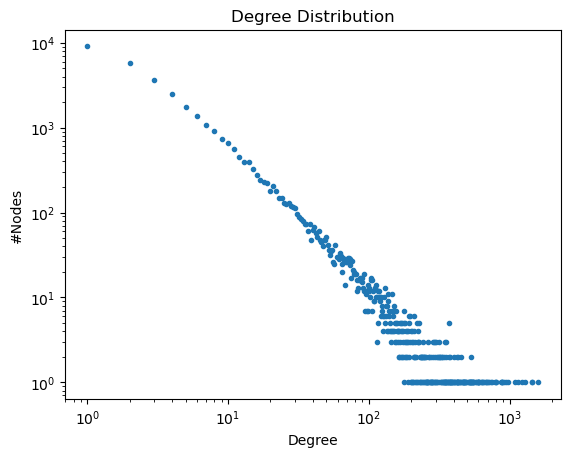

In [6]:
#the degree distribution is the following
plt.figure(1)
hist = nx.degree_histogram(g)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

Fit results

Calculating best minimal value for power law fit


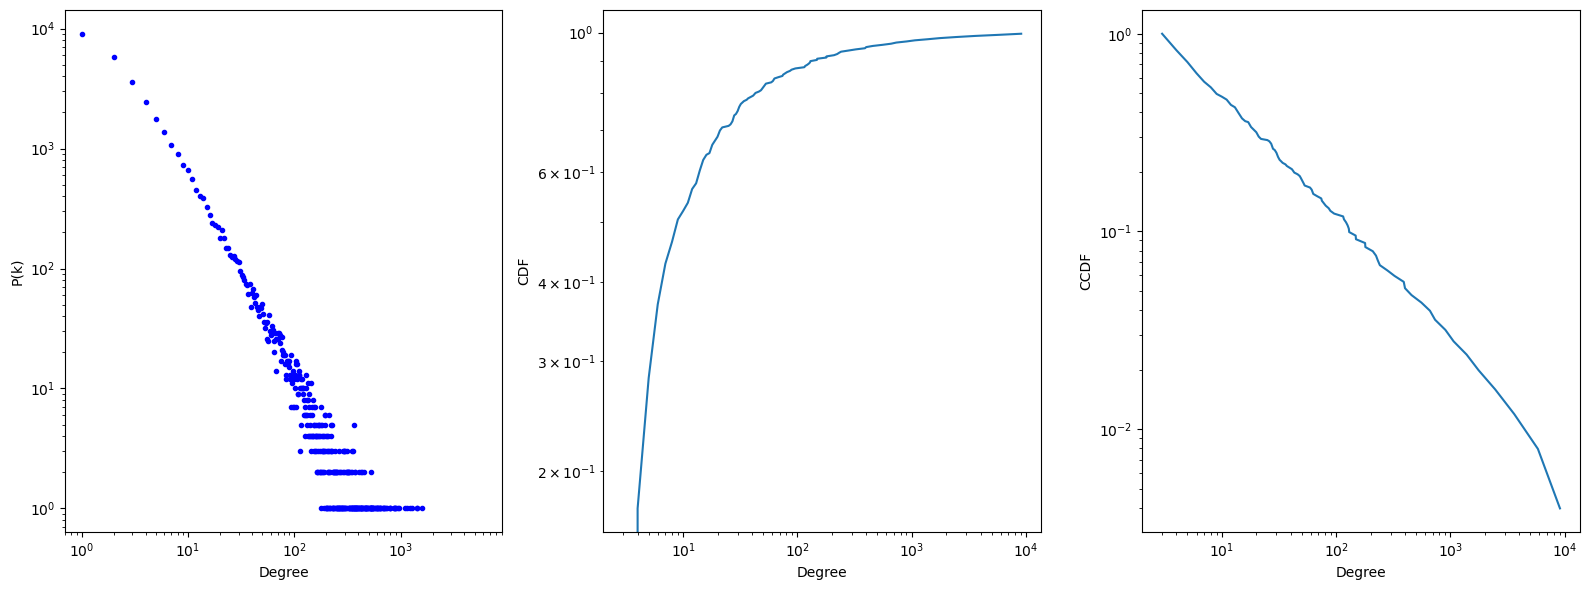

In [7]:
plot_dist(g)

## Connected components analysis

In [24]:
#number of connected components
N_conn_comp=nx.number_connected_components(g)
print("number of connected components",N_conn_comp)

# get a list of connected components (for decreasing size)
comps = list(nx.connected_components(g))

# Considering only giant component
g_giant_comp=g.subgraph(comps[0])

N_giant_nodes=g_giant_comp.number_of_nodes()
print("number of nodes",N_giant_nodes)

#number of edges
N_giant_edges=g_giant_comp.number_of_edges()
print("number of edges",N_giant_edges)

#density
density=nx.density(g)
print("density",density)


number of connected components 38
number of nodes 35310
number of edges 244390
density 0.0003904199967925148


#### Diameter computation (approx)

In [11]:
#diameter of the giant component
diameter_giant_comp=approximation.diameter(g_giant_comp)
print("diameter of the giant component",diameter_giant_comp)

diameter of the giant component 9


#### Shortest path on a sample of nodes

In [12]:
#shortest path
n_samples=10000
nodes = g_giant_comp.nodes()
lengths = []
for _ in range(n_samples):
    n1, n2 = random.choices(list(nodes), k=2)
    length = nx.shortest_path_length(g_giant_comp, source=n1, target=n2)
    lengths.append(length)

print('shortest path mean:', np.mean(lengths))

shortest path mean: 3.5971


Average cluster coeffincient

In [14]:
 # compute the average clustering coefficient
print("cluster_average",nx.average_clustering(g_giant_comp))

cluster_average 0.06602559235381902


#### Plot of cluster distribution

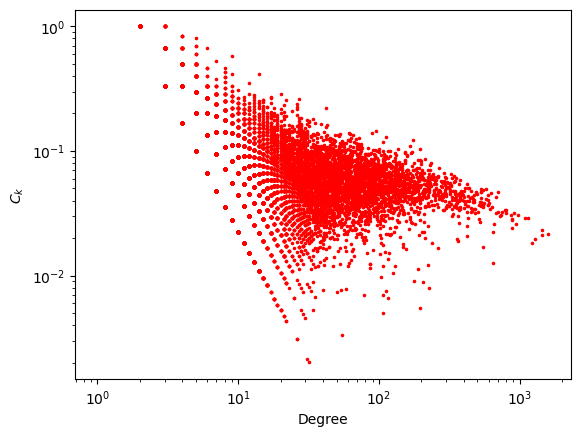

In [25]:
##cluster distribution

degrees=[degree for node, degree in g.degree()]
nodes=[node for node, degree in g.degree()]

c_k=[]

for node in nodes:
    c_k.append(nx.clustering(g, node))

plt.scatter(degrees,c_k, marker='.', color='red', s=10)
plt.xlabel("Degree")
plt.ylabel(r"$C_k$")
plt.minorticks_on()
plt.loglog()
plt.show()

### Degree Assortativity and Knn(k) distribution

degree_assortativity -0.048897348802351505


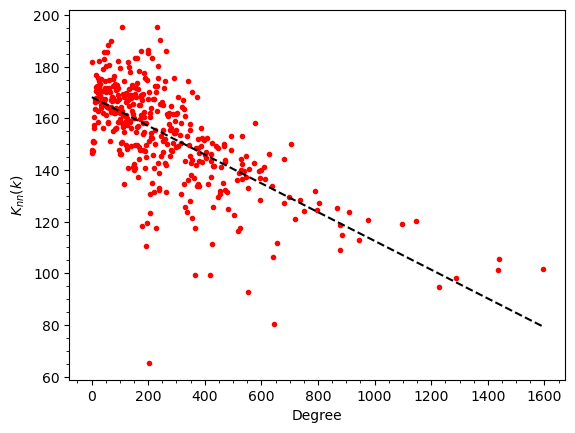

In [26]:
deg_assor=nx.degree_assortativity_coefficient(g_giant_comp)
print("degree_assortativity",deg_assor)

# KNN distribution
knn_distribution = nx.average_degree_connectivity(g_giant_comp)

degrees, knn_values = zip(*knn_distribution.items())

xx=np.linspace(min(degrees),max(degrees),10000)

pars, covm =curve_fit(cost,degrees,knn_values, absolute_sigma=False)
plt.scatter(degrees,knn_values, marker='.', color='red')
plt.errorbar(xx,cost(xx,*pars),color='black',linestyle='--')
plt.xlabel("Degree")
plt.ylabel(r"$K_{nn}(k)$")
plt.minorticks_on()
plt.show()

### Distance distribution

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.54it/s]


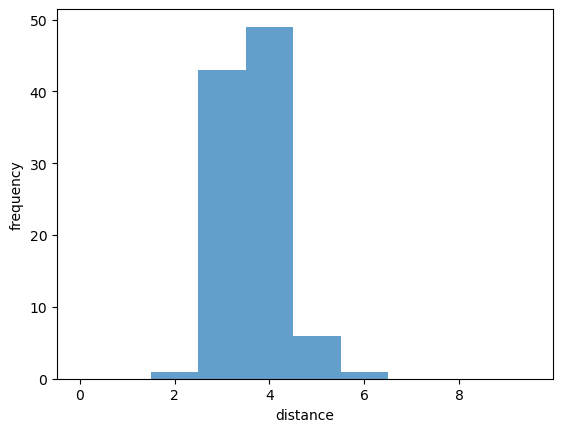

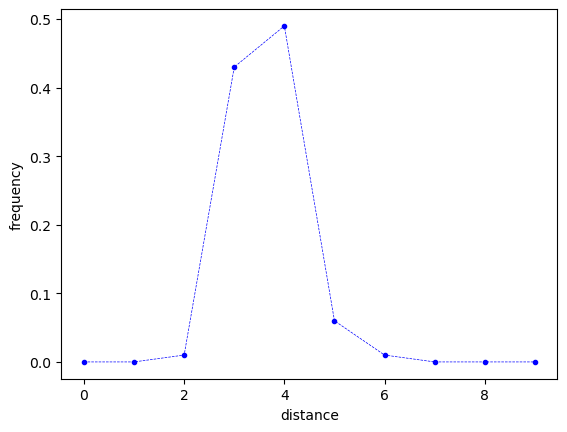

In [41]:
n_samples=100
nodes = g_giant_comp.nodes()
lengths = []
for _ in tqdm(range(n_samples)):
    n1, n2 = random.choices(list(nodes), k=2)
    length = nx.shortest_path_length(g_giant_comp, source=n1, target=n2)
    lengths.append(length)
n, bins, patches = plt.hist(lengths, bins=[0, 0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5],density=False,alpha=0.7)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.show()
plt.errorbar(np.arange(0,10,1),n/np.sum(n), marker='.', color='blue',linestyle='--', linewidth=0.5)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.show()

## Random networks

#### E-R

In [27]:
# E-R random network
er = nx.erdos_renyi_graph(N_nodes, Av_degree/(N_nodes-1))

#degree distribution
hist_er = nx.degree_histogram(er)

N_conn_comp_ER=nx.number_connected_components(er)
print("number of connected components E-R",N_conn_comp_ER)

# get a list of connected components (for decreasing size)
comps_er = list(nx.connected_components(er))

# Considering only giant component
er_giant_comp=er.subgraph(comps_er[0])

#density
density=nx.density(er)
print("density",density)

#cluster
print("cluster_average",nx.average_clustering(er))

#diameter
diameter_er=approximation.diameter(er_giant_comp)
print("diameter of the giant component",diameter_er)

#shortest path
n_samples=10000
nodes = er_giant_comp.nodes()
lengths = []
for _ in range(n_samples):
    n1, n2 = random.choices(list(nodes), k=2)
    length = nx.shortest_path_length(er_giant_comp, source=n1, target=n2)
    lengths.append(length)

print('shortest path mean:', np.mean(lengths))

number of connected components E-R 1
density 0.0003899935247325563
cluster_average 0.0004052916323998083
diameter of the giant component 6
shortest path mean: 4.2697


### B-A

In [30]:
m = 7
# B-A random network
ba = nx.barabasi_albert_graph(N_nodes, m)

#degree distribution
hist_ba = nx.degree_histogram(ba)

N_conn_comp_BA=nx.number_connected_components(ba)
print("number of connected components B-A",N_conn_comp_BA)

density=nx.density(ba)
print("density",density)
print("cluster_average",nx.average_clustering(ba))
#diameter
diameter_er=approximation.diameter(ba)
print("diameter of the giant component",diameter_er)
#shortest path
n_samples=10000
nodes = ba.nodes()
lengths = []
for _ in range(n_samples):
    n1, n2 = random.choices(list(nodes), k=2)
    length = nx.shortest_path_length(ba, source=n1, target=n2)
    lengths.append(length)

print('shortest path mean:', np.mean(lengths))


number of connected components B-A 1
density 0.00039556960698467316
cluster_average 0.003090219631147553
diameter of the giant component 5
shortest path mean: 3.6873


Plot of degree distribution of random and real networks

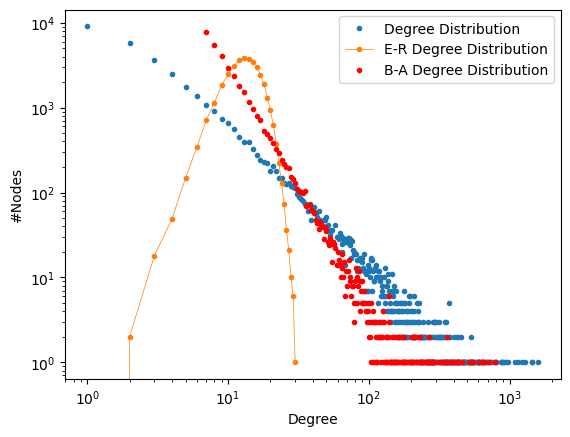

In [31]:
##Plot Distribution 

plt.errorbar(range(0, len(hist)), hist, marker='.',linestyle='',label="Degree Distribution")

plt.errorbar(range(0, len(hist_er)), hist_er, marker='.',linewidth=0.5, label="E-R Degree Distribution")

plt.errorbar(range(0, len(hist_ba)), hist_ba, marker='.', linestyle='',label="B-A Degree Distribution", color='red')

plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.legend()
plt.show()